### RNN Economic Choice No Hold

Hopefully it works

In [1]:
# --- Imports ---
import os
import sys
import random
import pickle
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_no_hold import EconomicChoiceEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve, load_model, save_model

# --- Set Random Seeds ---
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

2025-05-24 16:40:35.853631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748097637.654991  164177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748097638.099023  164177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748097642.007472  164177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748097642.007532  164177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748097642.007534  164177 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.


Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [10, 10, 20, 20]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 20000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Starting training for 20000 episodes...


2025-05-23 12:43:46.395559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0416	Critic Loss: 0.0013
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0581	Critic Loss: 0.0020
Episode 300	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0398	Critic Loss: 0.0007
Episode 400	Total Reward: 1.03	State [ 0.  -1.   0.2  0.1]	Actor Loss: 0.5798	Critic Loss: 0.8953
Episode 500	Total Reward: -0.09	State [ 1.  -1.   0.1  0.1]	Actor Loss: -0.2220	Critic Loss: 0.0214
Episode 600	Total Reward: 2.02	State [0.  1.  0.2 0.1]	Actor Loss: 0.9166	Critic Loss: 3.1016
Episode 700	Total Reward: 2.21	State [ 0.  -1.   0.1  0.4]	Actor Loss: 0.1408	Critic Loss: 1.3345
Episode 800	Total Reward: 2.21	State [ 0.  -1.   0.1  1. ]	Actor Loss: 0.0068	Critic Loss: 0.2339
Episode 900	Total Reward: 2.01	State [0.  1.  0.2 0.1]	Actor Loss: -0.0449	Critic Loss: 0.2208
Episode 1000	Total Reward: 10.01	State [0.  1.  1.  0.1]	Actor Loss: 0.5236	Critic Loss: 65.9254
Episode 1100	Total Reward: 2.22	State [ 0.  

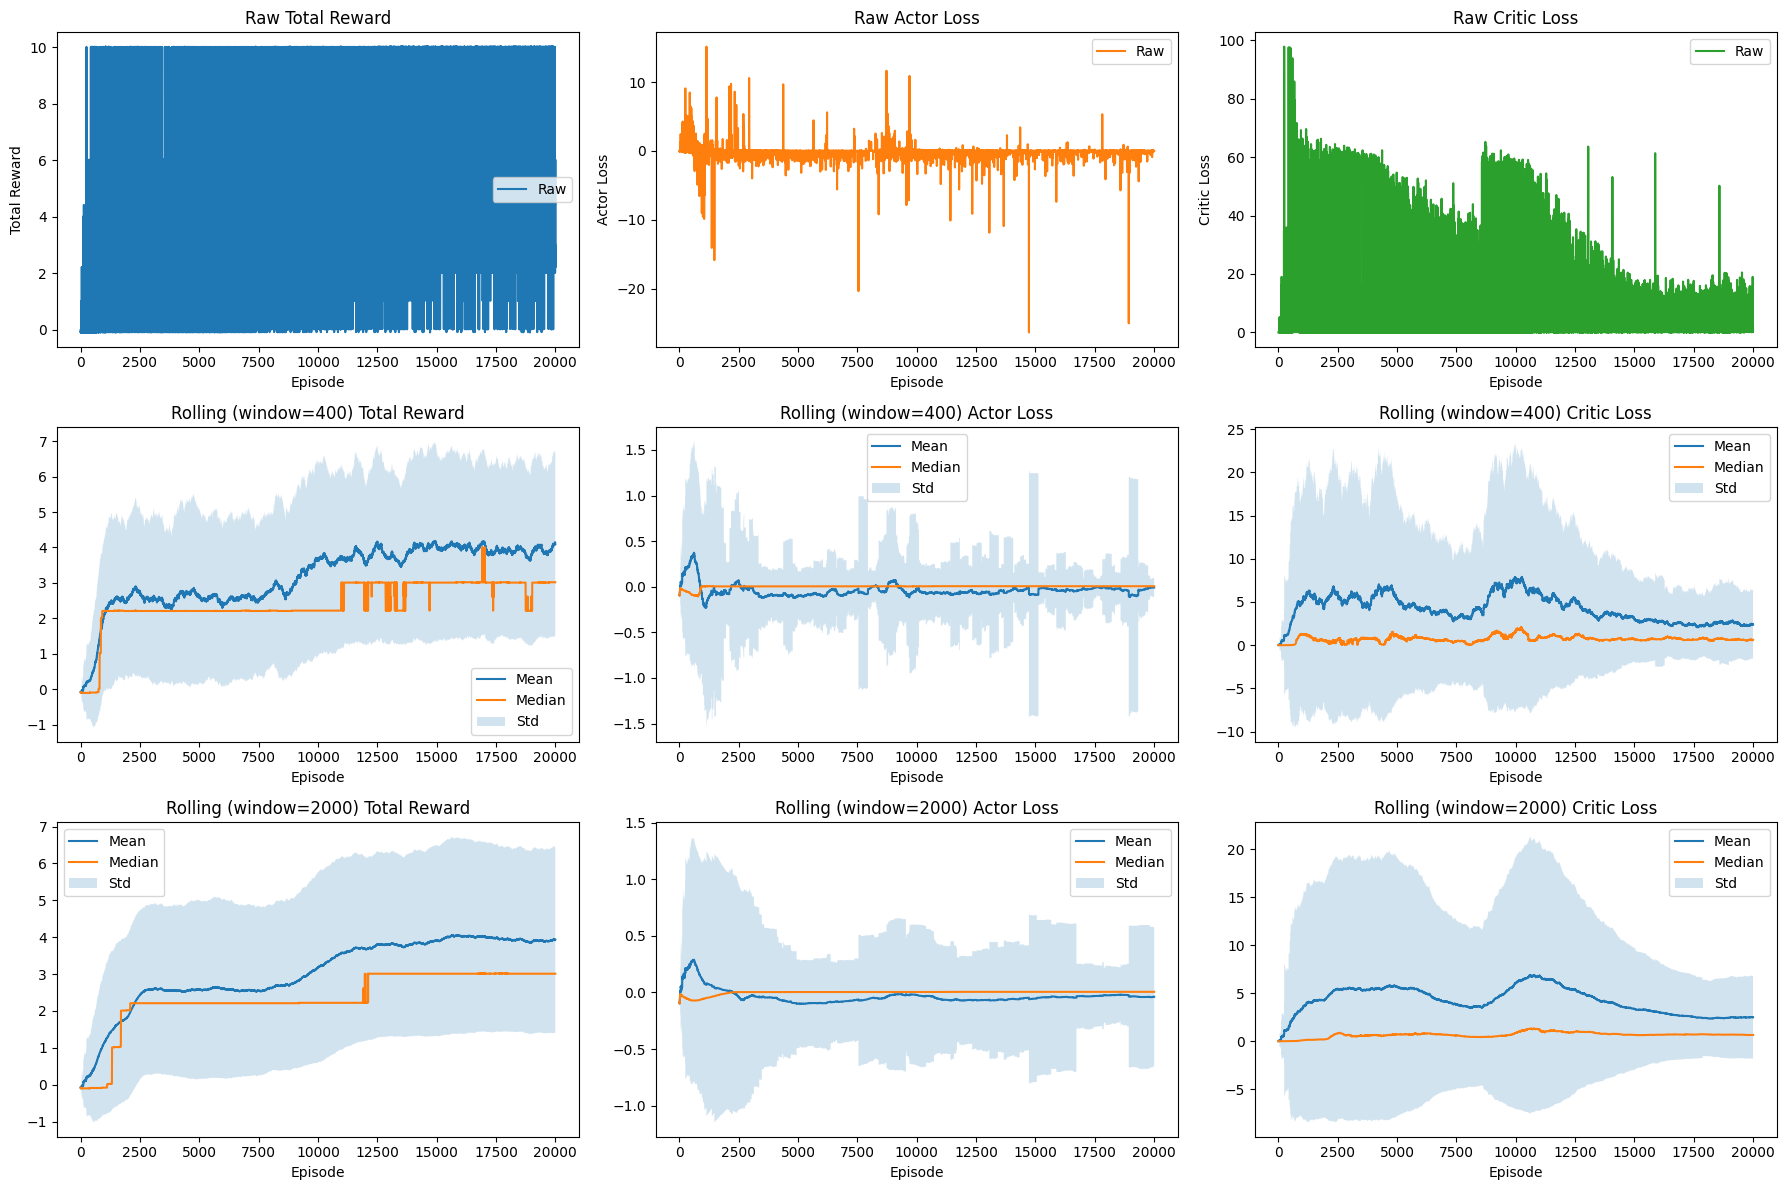

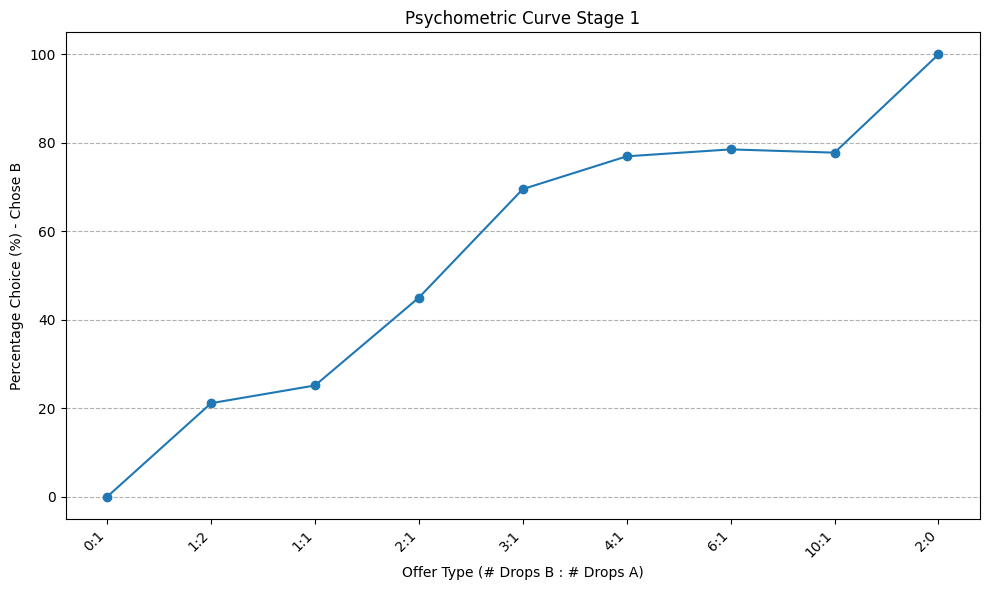

Closing the environment...
Environment closed.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.0,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "duration_params": [10, 10, 20, 20],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, \
    actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"],
        print_interval=config["print_interval"],
        l2_actor=config["l2_actor"],
        l2_critic=config["l2_critic"],
        record_history=config["record_history"]
    )
    print("\nTraining finished.")

    # --- Save checkpoint ---
    this_stage = 1
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / "rnn_nohold_max.pkl"
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Training Metrics & Psychometric Curve ---
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config["num_episodes"] // 50),
        window_2=max(50, config["num_episodes"] // 10)
    )
    plot_psychometric_curve(
        measurements_juices,
        title="Psychometric Curve Stage 1"
    )

    # --- Close Environment ---
    print("Closing the environment...")
    env.close()
    print("Environment closed.")

if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [30, 20, 40, 40]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 1...
Masks loaded.
Initializing optimizers with dummy step...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_1/ckpt-1
Checkpoint restored successfully.
Starting training for 10000 episodes...
Episode 100	Total Reward: 0.06	State [0.         1.         0.3051437  0.09130482]	Actor Loss: -0.0122	Critic Loss: 3.8148
Episode 200	Total Reward: -0.04	State [1.         1.         0.5091487  0.11796545]	Actor Loss: 0.0017	Critic Loss: 13.5137
Episode 300	Total Reward: 2.27	State [0.         1.         0.08211086 0.        ]	Actor Loss: 0.0096	Critic Loss: 0.2178
Episode 400	Total Reward: 10.04	State [ 0.        -1.         0.         1.0874604]	Actor Loss: 0.0070	Critic Loss: 23.8931
Episode 500	Total Reward: 3.05	State [0.         1.         0.36659467 0.1420771 ]	Actor Loss: 0.0057	Critic Loss: 0.2980
Episode 600	Total Reward: 4.44	State [0.         1.         0.02338412 0.21830505]	Actor Loss: 0.0057	Critic Loss: 2.7522
Episode 700	Total Reward: 4.05	State [ 0.         -1.          0.06261311  0.3270381 ]	Actor Loss: 0.0

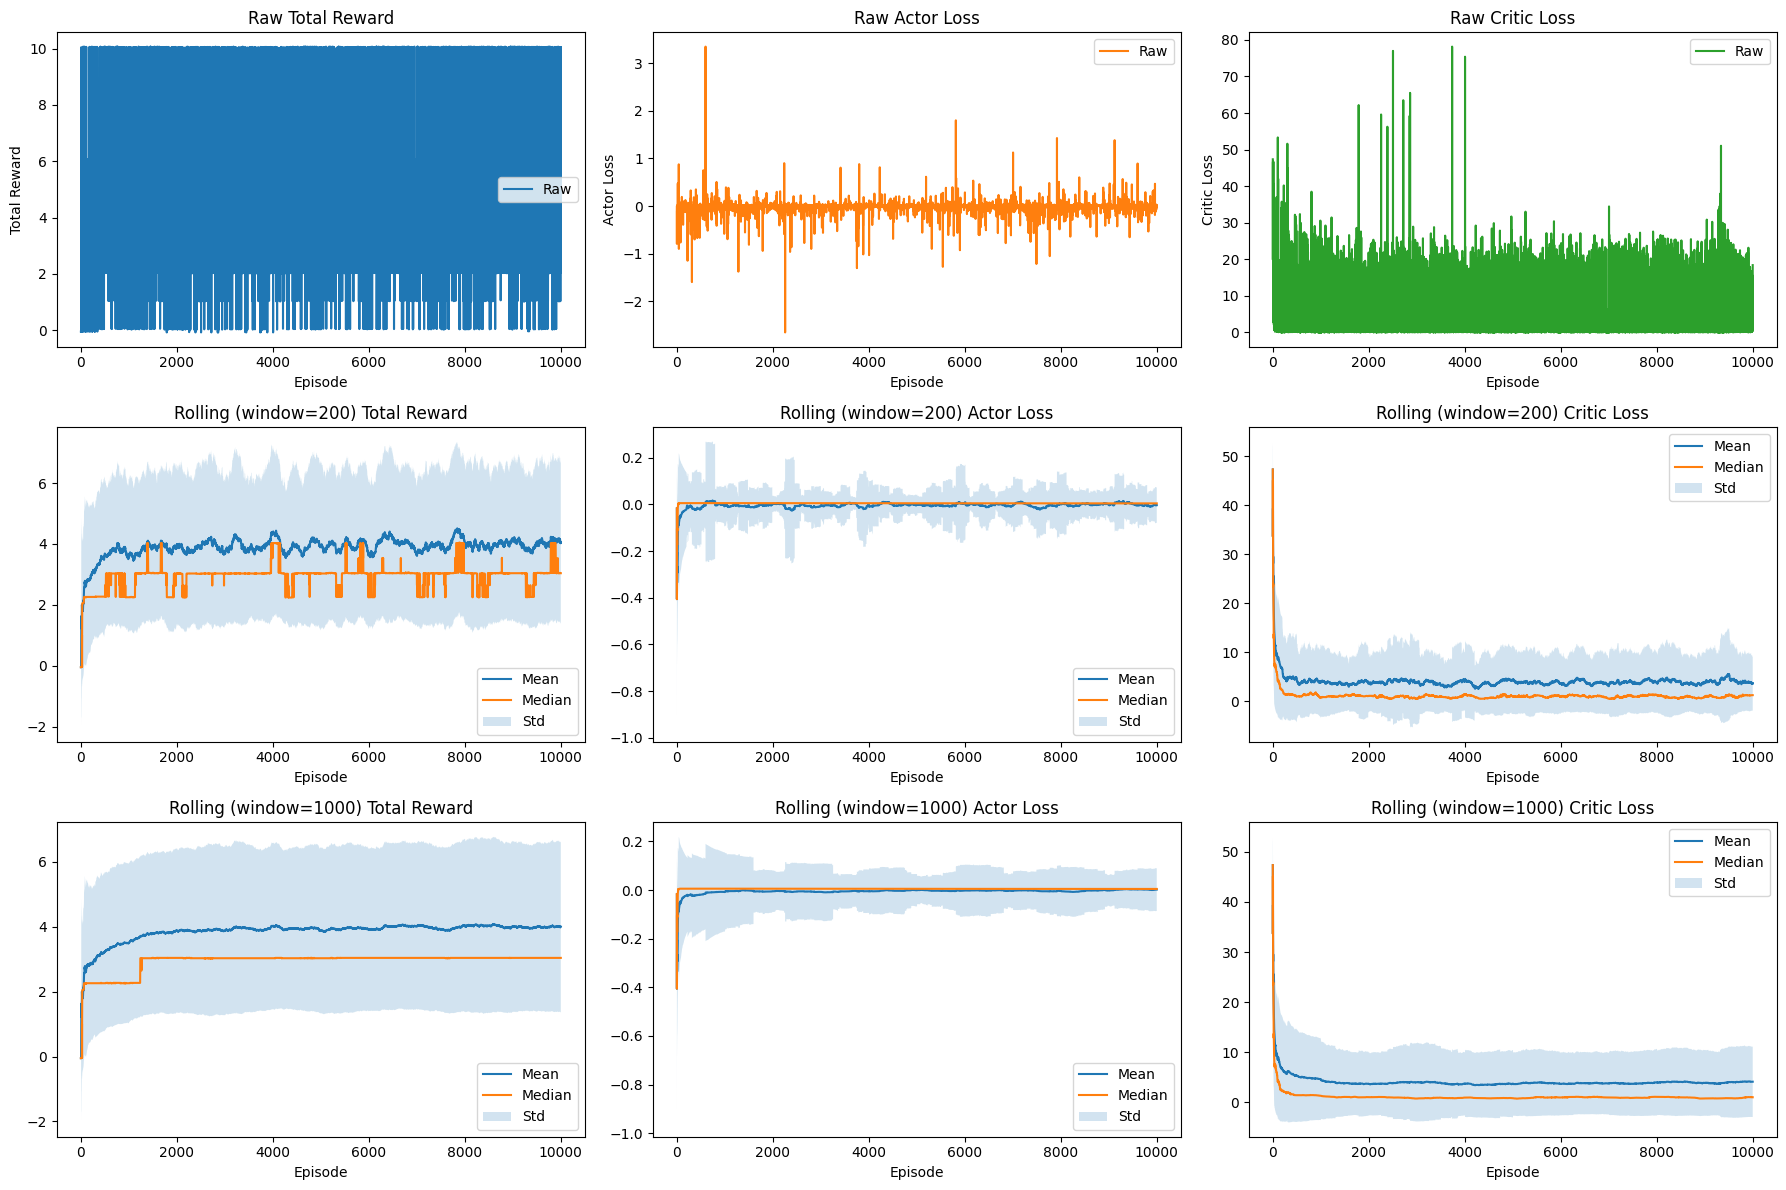

Plotting psychometric curve...


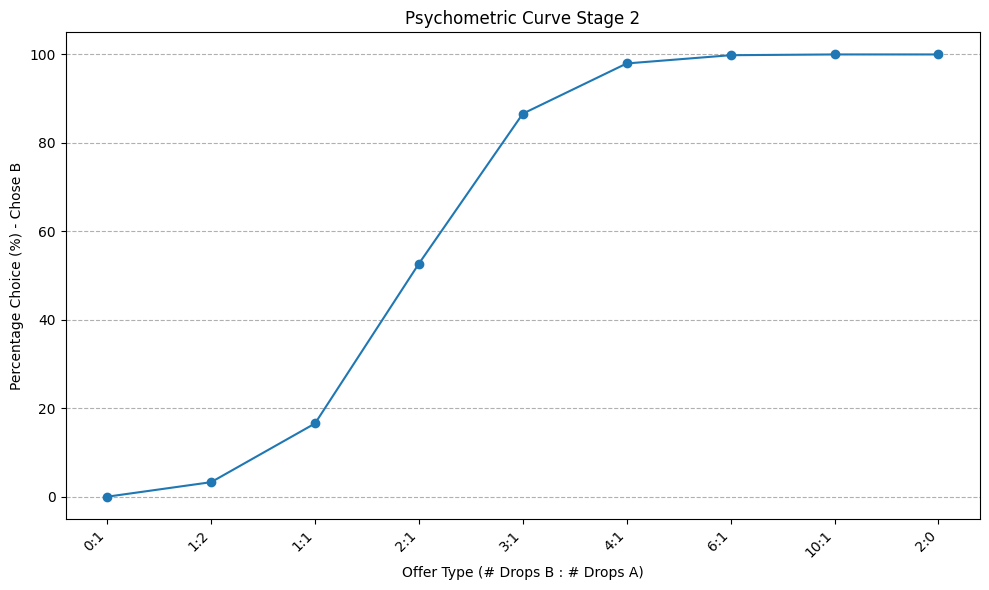

Closing environment...
Done.


In [3]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "duration_params": [30, 20, 40, 40],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 10000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 3 finished.")

    # --- Save checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_2.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 2")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [60, 40, 80, 80]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.003
  critic_lr: 0.003
  num_episodes: 10000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...


2025-05-23 18:53:11.029726: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Loading masks from stage 2...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_2/ckpt-1
Checkpoint restored successfully.
Starting training for 10000 episodes...


Episode 100	Total Reward: 2.12	State [ 0.         -1.          0.19802576  0.25356135]	Actor Loss: 0.0039	Critic Loss: 0.2413
Episode 200	Total Reward: 2.27	State [0.         1.         0.02969852 0.0249029 ]	Actor Loss: 0.0037	Critic Loss: 0.0803
Episode 300	Total Reward: 2.30	State [0.         1.         0.03415054 0.00524874]	Actor Loss: 0.0043	Critic Loss: 0.3519
Episode 400	Total Reward: 4.50	State [ 0.         -1.          0.06105417  0.07679837]	Actor Loss: 0.0060	Critic Loss: 2.9679
Episode 500	Total Reward: 1.13	State [ 0.         -1.          0.08349127  0.09674288]	Actor Loss: -0.0163	Critic Loss: 5.5964
Episode 600	Total Reward: 2.08	State [0.         1.         0.16287553 0.06042711]	Actor Loss: 0.0045	Critic Loss: 0.8463
Episode 700	Total Reward: 4.07	State [ 0.         -1.          0.10587676  0.36191887]	Actor Loss: 0.0050	Critic Loss: 1.6032
Episode 800	Total Reward: 10.09	State [ 0.         -1.          0.03594542  0.7716707 ]	Actor Loss: 0.0046	Critic Loss: 28.0230
E

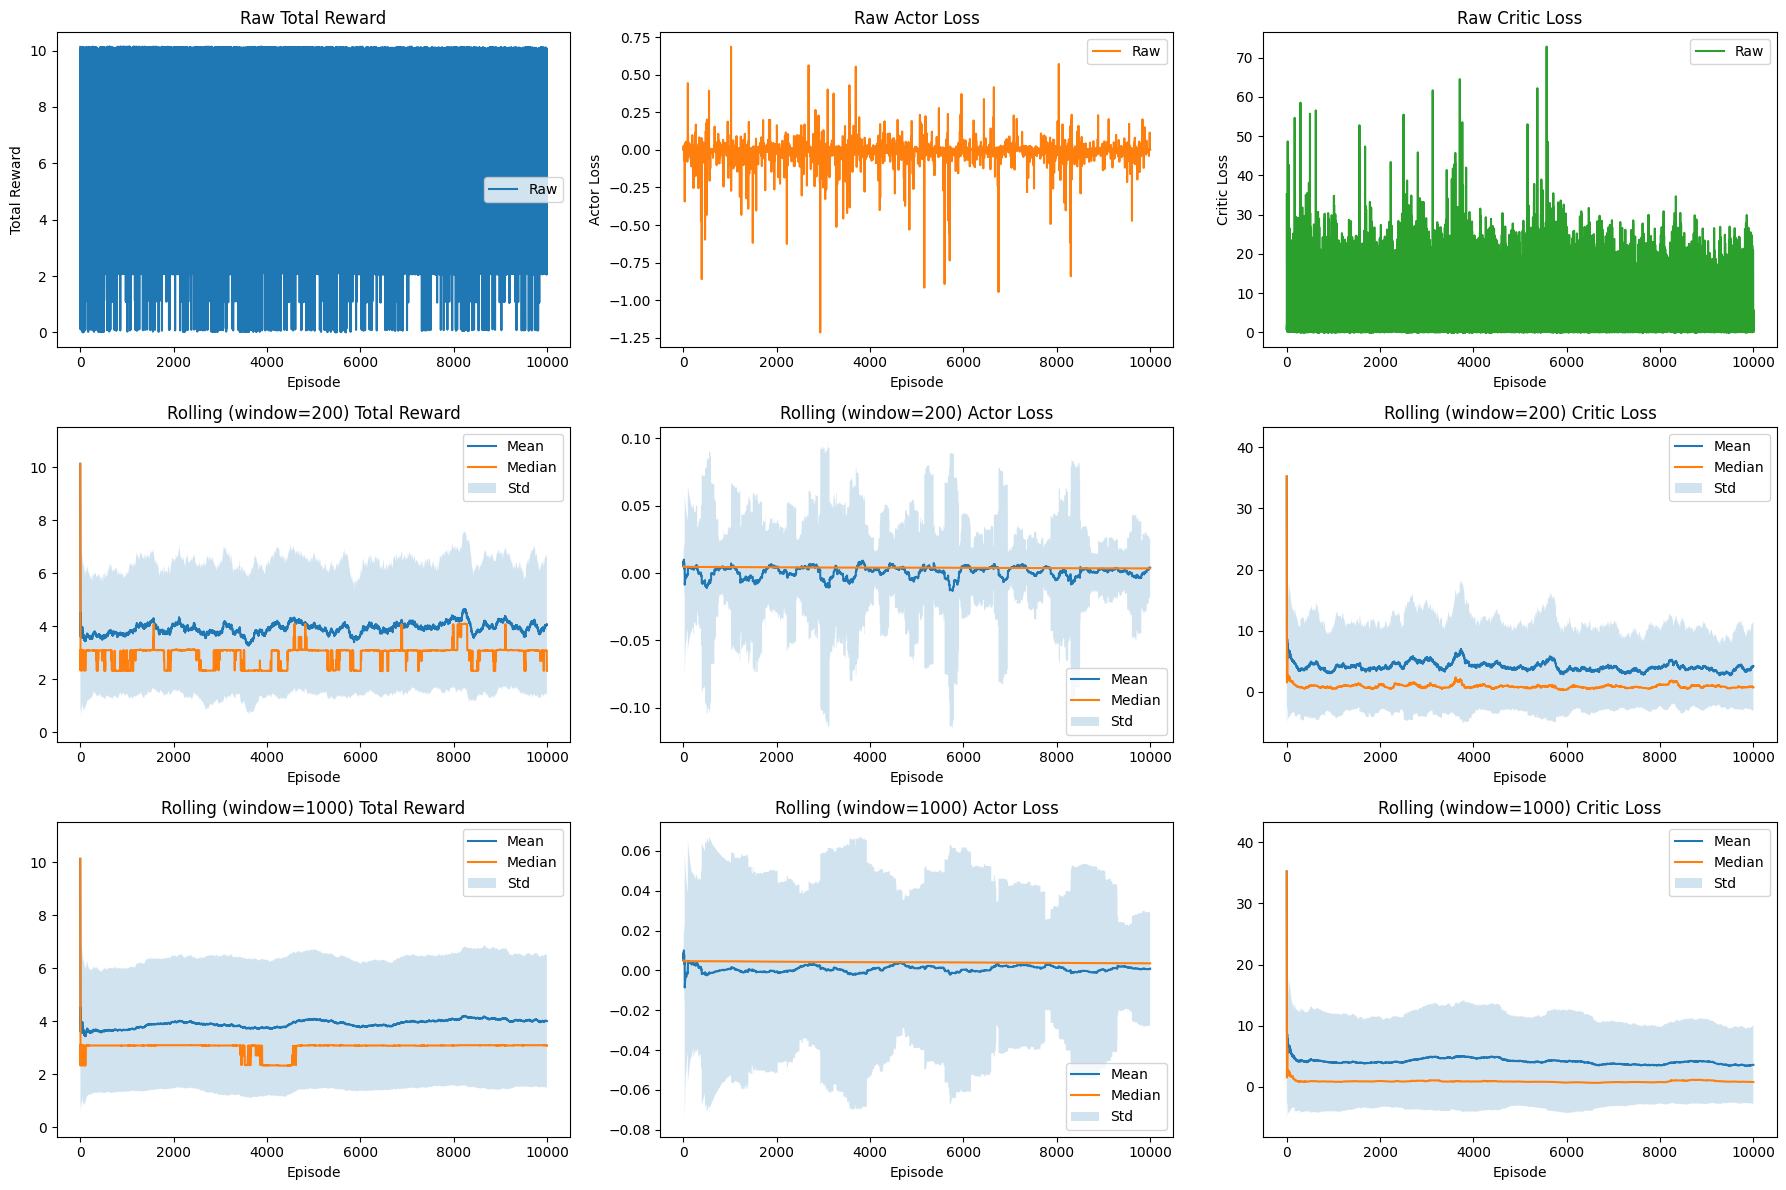

Plotting psychometric curve...


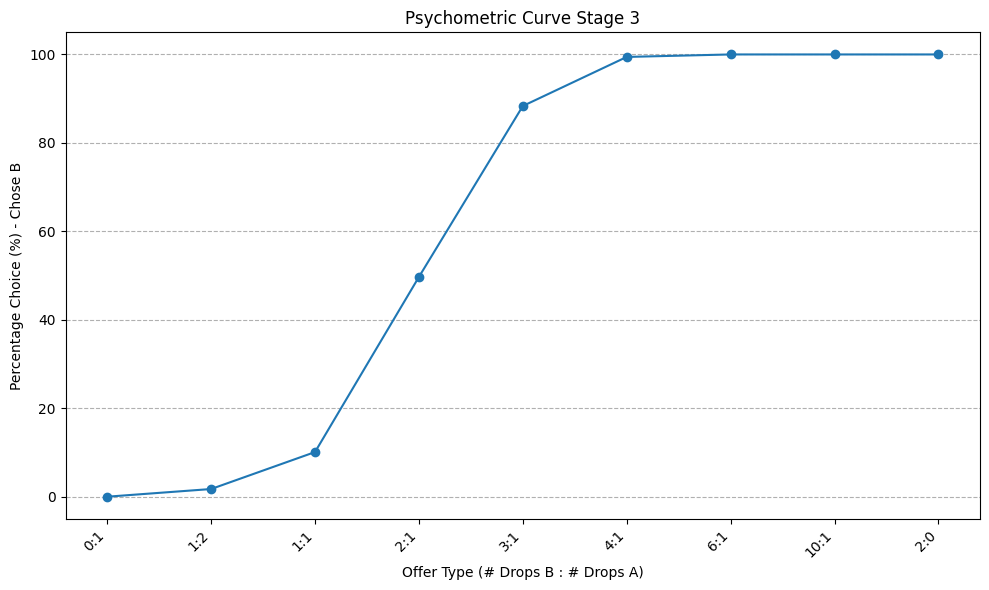

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "duration_params": [60, 40, 80, 80],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 3e-3,
        "critic_lr": 3e-3,
        "num_episodes": 10000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 3 finished.")

    # --- Save checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_3.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 3")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  duration_params: [120, 80, 160, 160]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.002
  critic_lr: 0.002
  num_episodes: 2000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 3...
Masks loaded.
Initializing optimizers with dummy step...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_3/ckpt-1
Checkpoint restored successfully.
Starting training for 2000 episodes...
Episode 100	Total Reward: 2.40	State [0.         1.         0.08980387 0.16759372]	Actor Loss: 0.0035	Critic Loss: 0.1895
Episode 200	Total Reward: 2.43	State [ 0.         -1.          0.19477776  0.457077  ]	Actor Loss: 0.0024	Critic Loss: 0.2115
Episode 300	Total Reward: 2.38	State [0.         1.         0.22299899 0.14919811]	Actor Loss: 0.0034	Critic Loss: 1.3329
Episode 400	Total Reward: 4.65	State [ 0.         -1.          0.08543506  0.12817888]	Actor Loss: 0.0064	Critic Loss: 3.7698
Episode 500	Total Reward: 4.21	State [ 0.         -1.          0.27621043  0.16630055]	Actor Loss: 0.0035	Critic Loss: 0.4551
Episode 600	Total Reward: 6.21	State [ 0.         -1.          0.          0.34488156]	Actor Loss: 0.0034	Critic Loss: 5.3361
Episode 700	Total Reward: 3.24	State [ 0.         -1.          0.16921449  0.34209493]	Actor

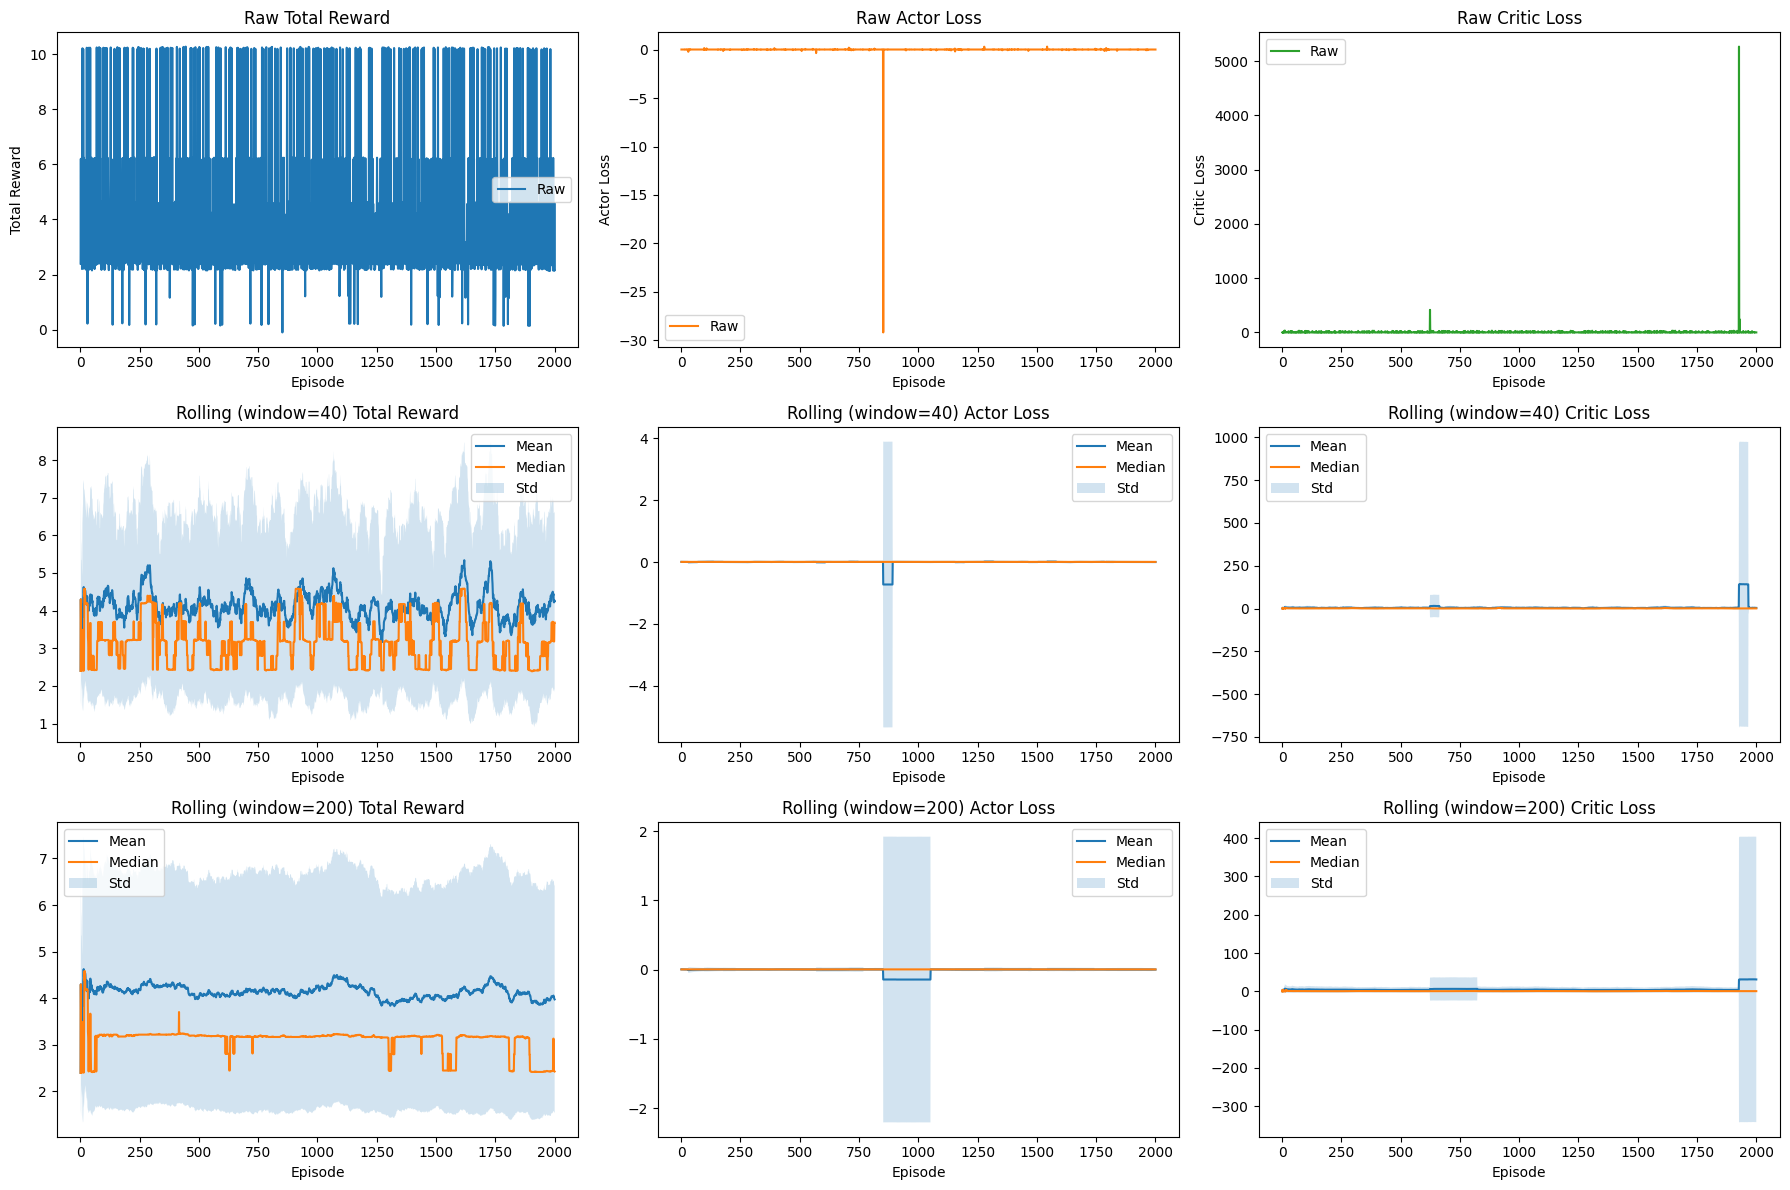

Plotting psychometric curve...


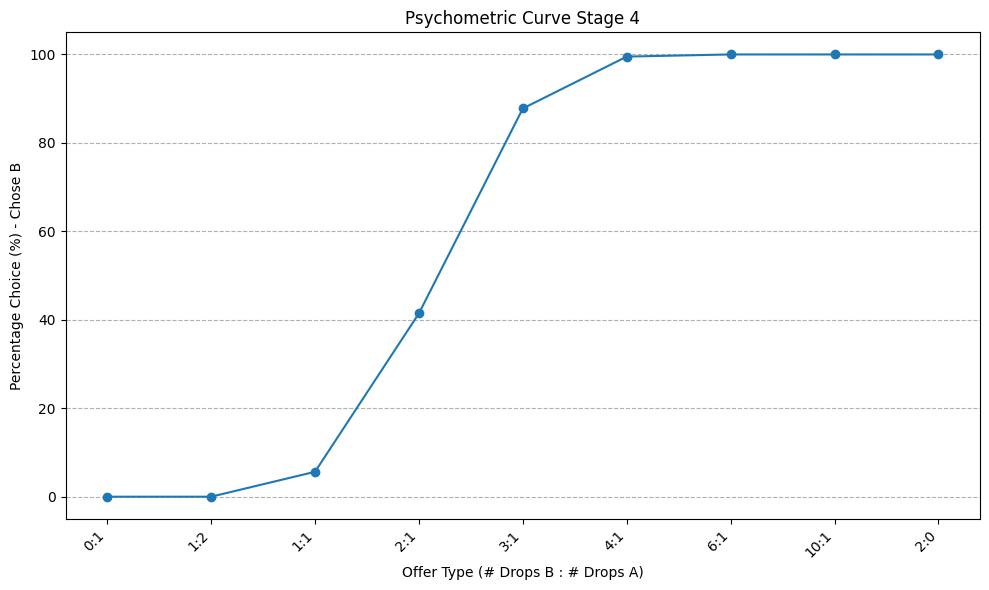

Closing environment...
Done.


In [3]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "duration_params": [120, 80, 160, 160],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 2e-3,
        "critic_lr": 2e-3,
        "num_episodes": 2000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 4
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 4 finished.")

    # --- Save checkpoint ---
    this_stage = 4
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_4.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 4")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.001
  reward_go_fixation: -0.01
  duration_params: [240, 160, 320, 320]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.002
  critic_lr: 0.002
  num_episodes: 1000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...


2025-05-24 10:05:28.382728: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Loading masks from stage 4...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_4/ckpt-1
Checkpoint restored successfully.
Starting training for 1000 episodes...
Episode 100	Total Reward: 1.99	State [ 0.         -1.          0.02016119  0.13547978]	Actor Loss: 0.0032	Critic Loss: 0.4150
Episode 200	Total Reward: 2.17	State [0.         1.         0.04727557 0.09425974]	Actor Loss: 0.0034	Critic Loss: 0.1304
Episode 300	Total Reward: 2.18	State [0.         1.         0.         0.11334193]	Actor Loss: 0.0032	Critic Loss: 0.5770
Episode 400	Total Reward: 4.40	State [ 0.         -1.          0.16607104  0.        ]	Actor Loss: 0.0036	Critic Loss: 3.6348
Episode 500	Total Reward: 2.19	State [ 0.         -1.          0.16374446  0.22344305]	Actor Loss: 0.0031	Critic Loss: 1.0837
Episode 600	Total Reward: 1.98	State [0.        1.        0.1985389 0.       ]	Actor Loss: 0.0027	Critic Loss: 0.9731
Episode 700	T

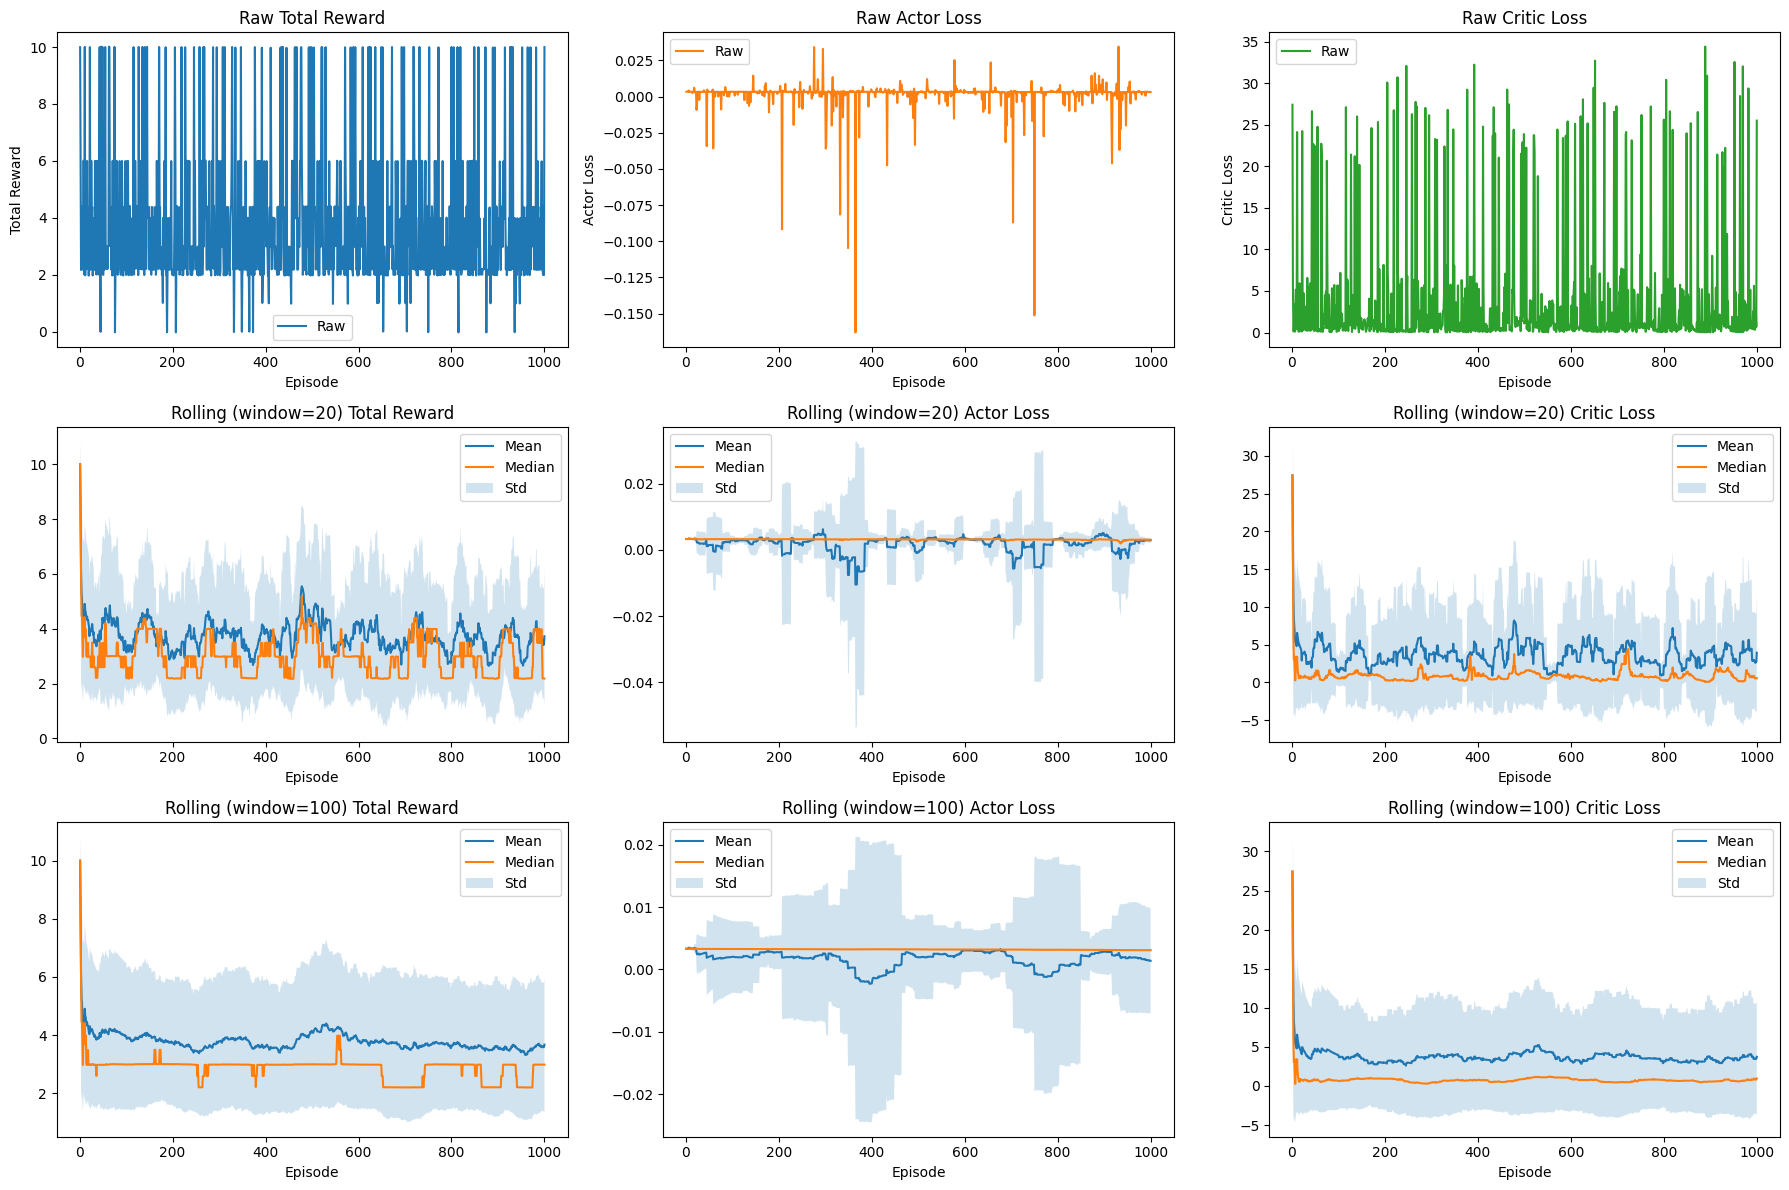

Plotting psychometric curve...


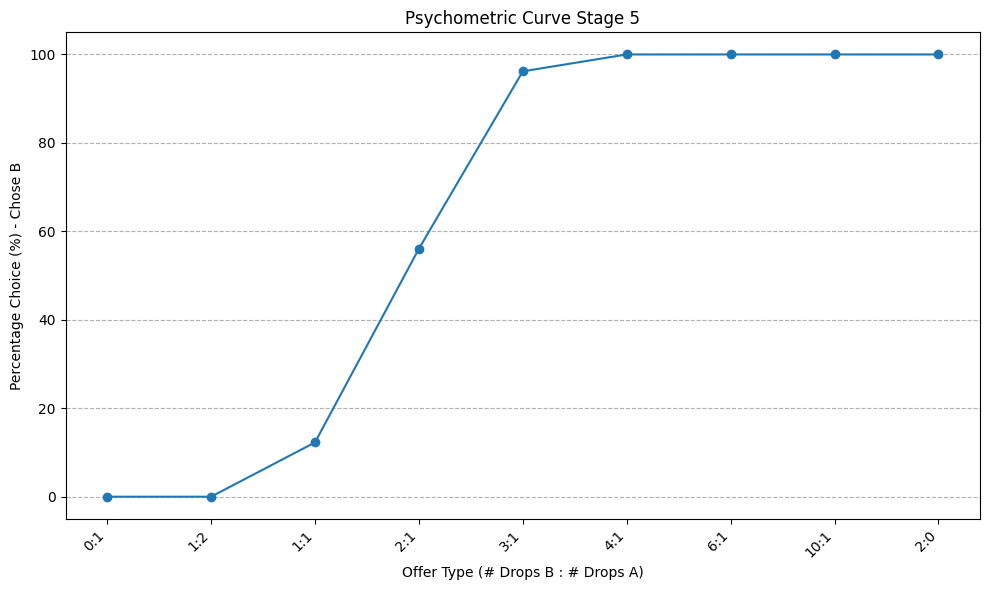

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.001,
        "reward_go_fixation": -0.01,
        "duration_params": [240, 160, 320, 320],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 2e-3,
        "critic_lr": 2e-3,
        "num_episodes": 1000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 5
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 5 finished.")

    # --- Save checkpoint ---
    this_stage = 5
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_5.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 5")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.001
  reward_go_fixation: -0.01
  duration_params: [480, 320, 640, 640]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 500
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...


2025-05-24 12:29:54.500090: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 5...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_5/ckpt-1
Checkpoint restored successfully.
Starting training for 500 episodes...
Episode 100	Total Reward: 2.04	State [ 0.        -1.         0.         0.2428691]	Actor Loss: 0.0024	Critic Loss: 0.6883
Episode 200	Total Reward: 2.24	State [0.         1.         0.         0.10430592]	Actor Loss: 0.0031	Critic Loss: 0.1042
Episode 300	Total Reward: 2.22	State [0.         1.         0.09364224 0.00586922]	Actor Loss: 0.0030	Critic Loss: 0.7764
Episode 400	Total Reward: 4.43	State [ 0.         -1.          0.25801787  0.15384494]	Actor Loss: 0.0033	Critic Loss: 3.4887
Episode 500	Total Reward: 1.03	State [ 0.         -1.          0.          0.01960689]	Actor Loss: -0.0519	Critic Loss: 6.0866
Training st

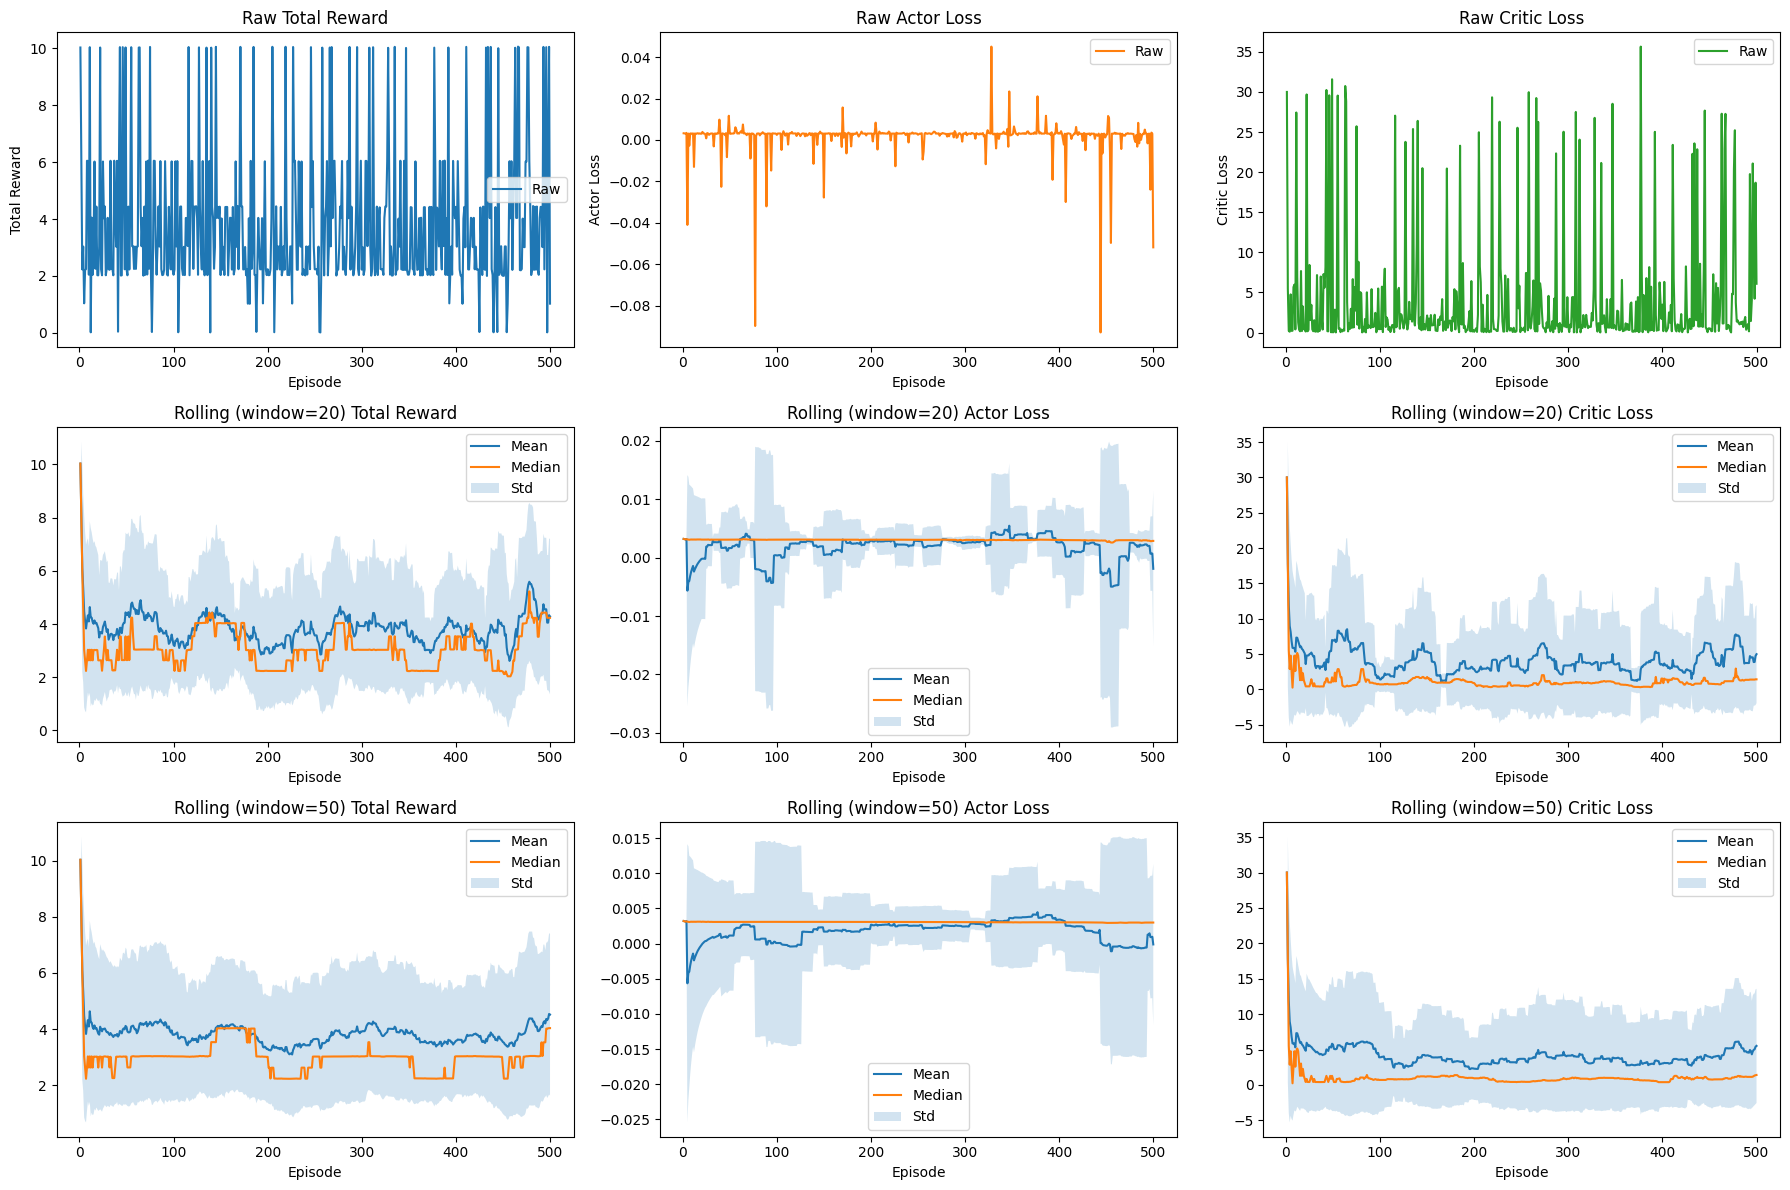

Plotting psychometric curve...


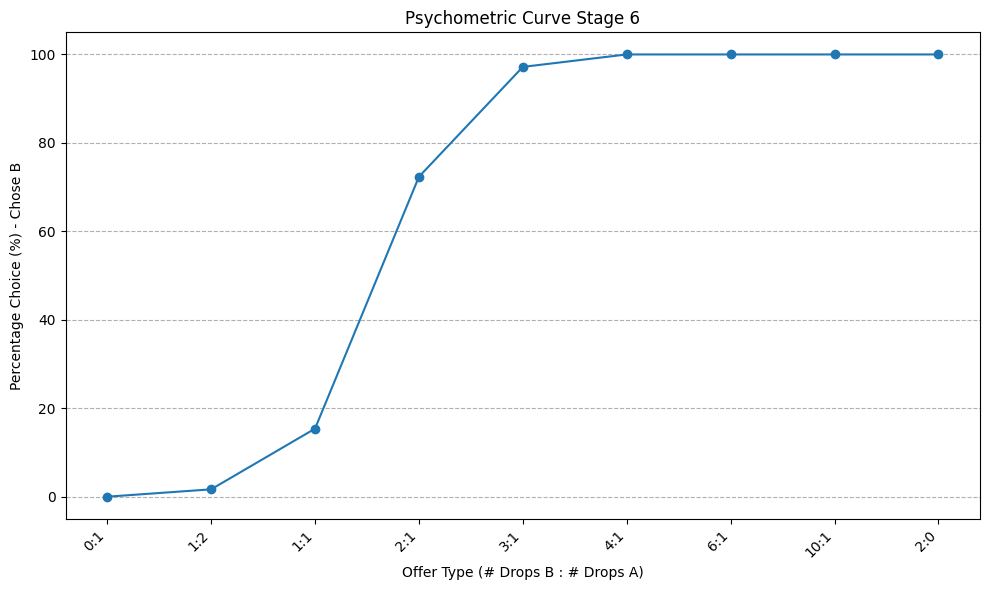

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.001,
        "reward_go_fixation": -0.01,
        "duration_params": [480, 320, 640, 640],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 500,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 6
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 6 finished.")

    # --- Save checkpoint ---
    this_stage = 6
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_6.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 6")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.001
  reward_go_fixation: -0.01
  duration_params: [480, 320, 640, 640]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 250
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...


2025-05-24 14:14:18.773350: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 6...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_6/ckpt-1
Checkpoint restored successfully.
Starting training for 250 episodes...
Episode 100	Total Reward: 2.24	State [ 0.         -1.          0.11916687  0.22624   ]	Actor Loss: 0.0004	Critic Loss: 0.2126
Episode 200	Total Reward: 2.21	State [0.         1.         0.02257704 0.16991265]	Actor Loss: 0.0030	Critic Loss: 0.2028
Training stage 7 finished.
Checkpoint stage 7 saved at: checkpoints/rnn_nohold_max_7/ckpt-1
Saving masks for stage 7...
Masks saved for stage 7.
Plotting training metrics...


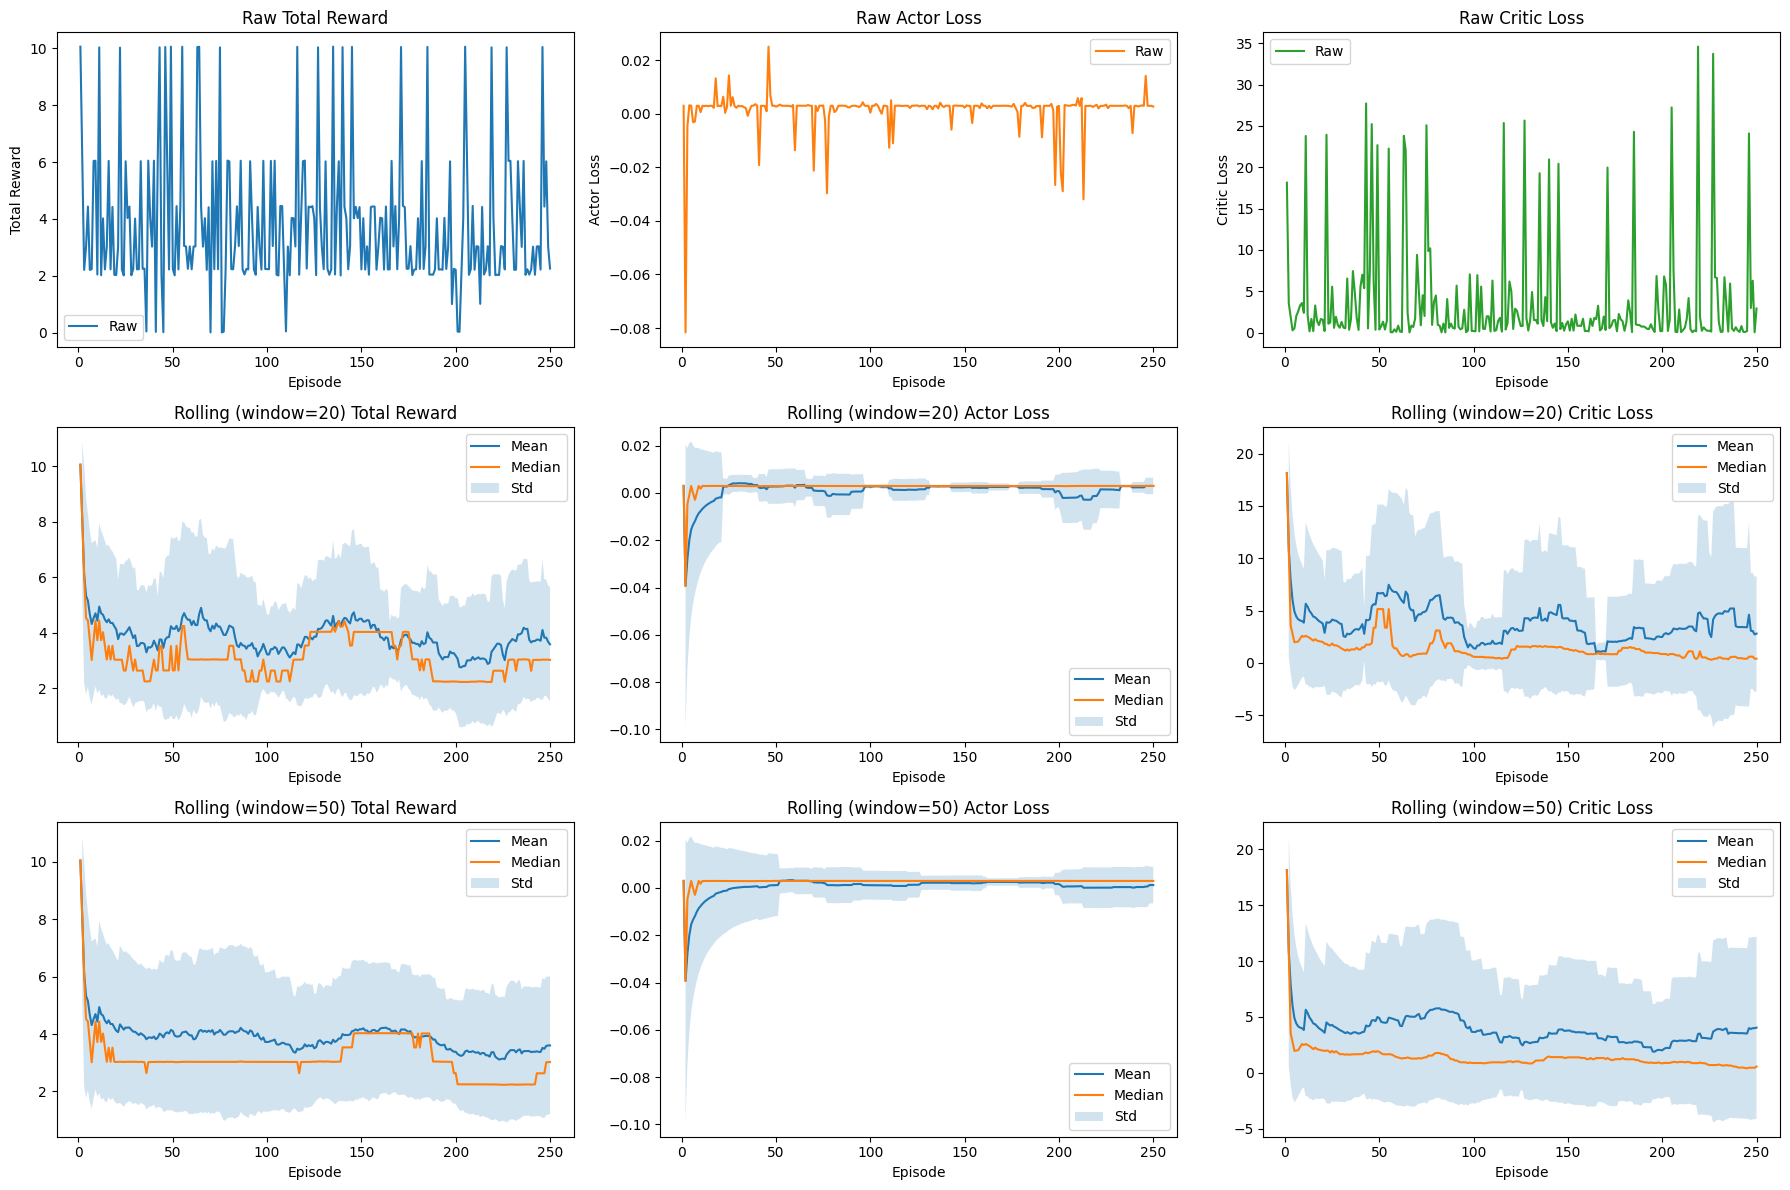

Plotting psychometric curve...


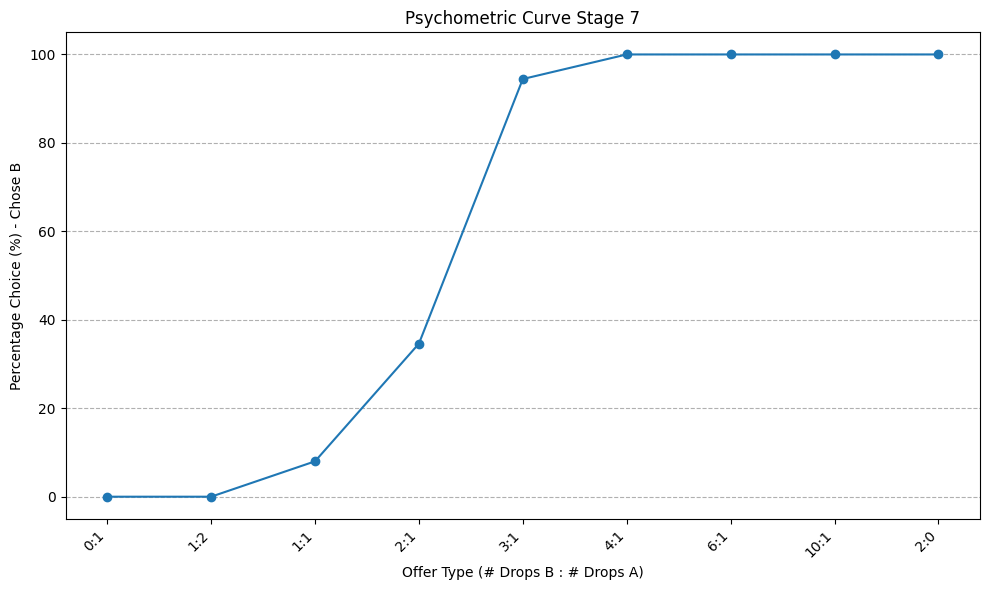

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.001,
        "reward_go_fixation": -0.01,
        "duration_params": [480, 320, 640, 640],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 250,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 7
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 7 finished.")

    # --- Save checkpoint ---
    this_stage = 7
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_7.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 7")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.001
  reward_go_fixation: -0.01
  duration_params: [960, 640, 1280, 1280]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 200
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 50
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 7...
Masks loaded.
Initializing optimizers with dummy step...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_7/ckpt-1
Checkpoint restored successfully.
Starting training for 200 episodes...
Episode 50	Total Reward: 6.15	State [ 0.         -1.          0.12421405  0.6364348 ]	Actor Loss: 0.0030	Critic Loss: 5.0781
Episode 100	Total Reward: 2.34	State [ 0.         -1.          0.12309315  0.        ]	Actor Loss: 0.0030	Critic Loss: 0.3508
Episode 150	Total Reward: 3.13	State [0.         1.         0.29519668 0.2793643 ]	Actor Loss: 0.0038	Critic Loss: 0.0311
Episode 200	Total Reward: 2.11	State [ 0.         -1.          0.12192369  0.28481683]	Actor Loss: 0.0029	Critic Loss: 0.4962
Training stage 8 finished.
Checkpoint stage 8 saved at: checkpoints/rnn_nohold_max_8/ckpt-1
Saving masks for stage 8...
Masks saved for stage 8.
Plotting training metrics...


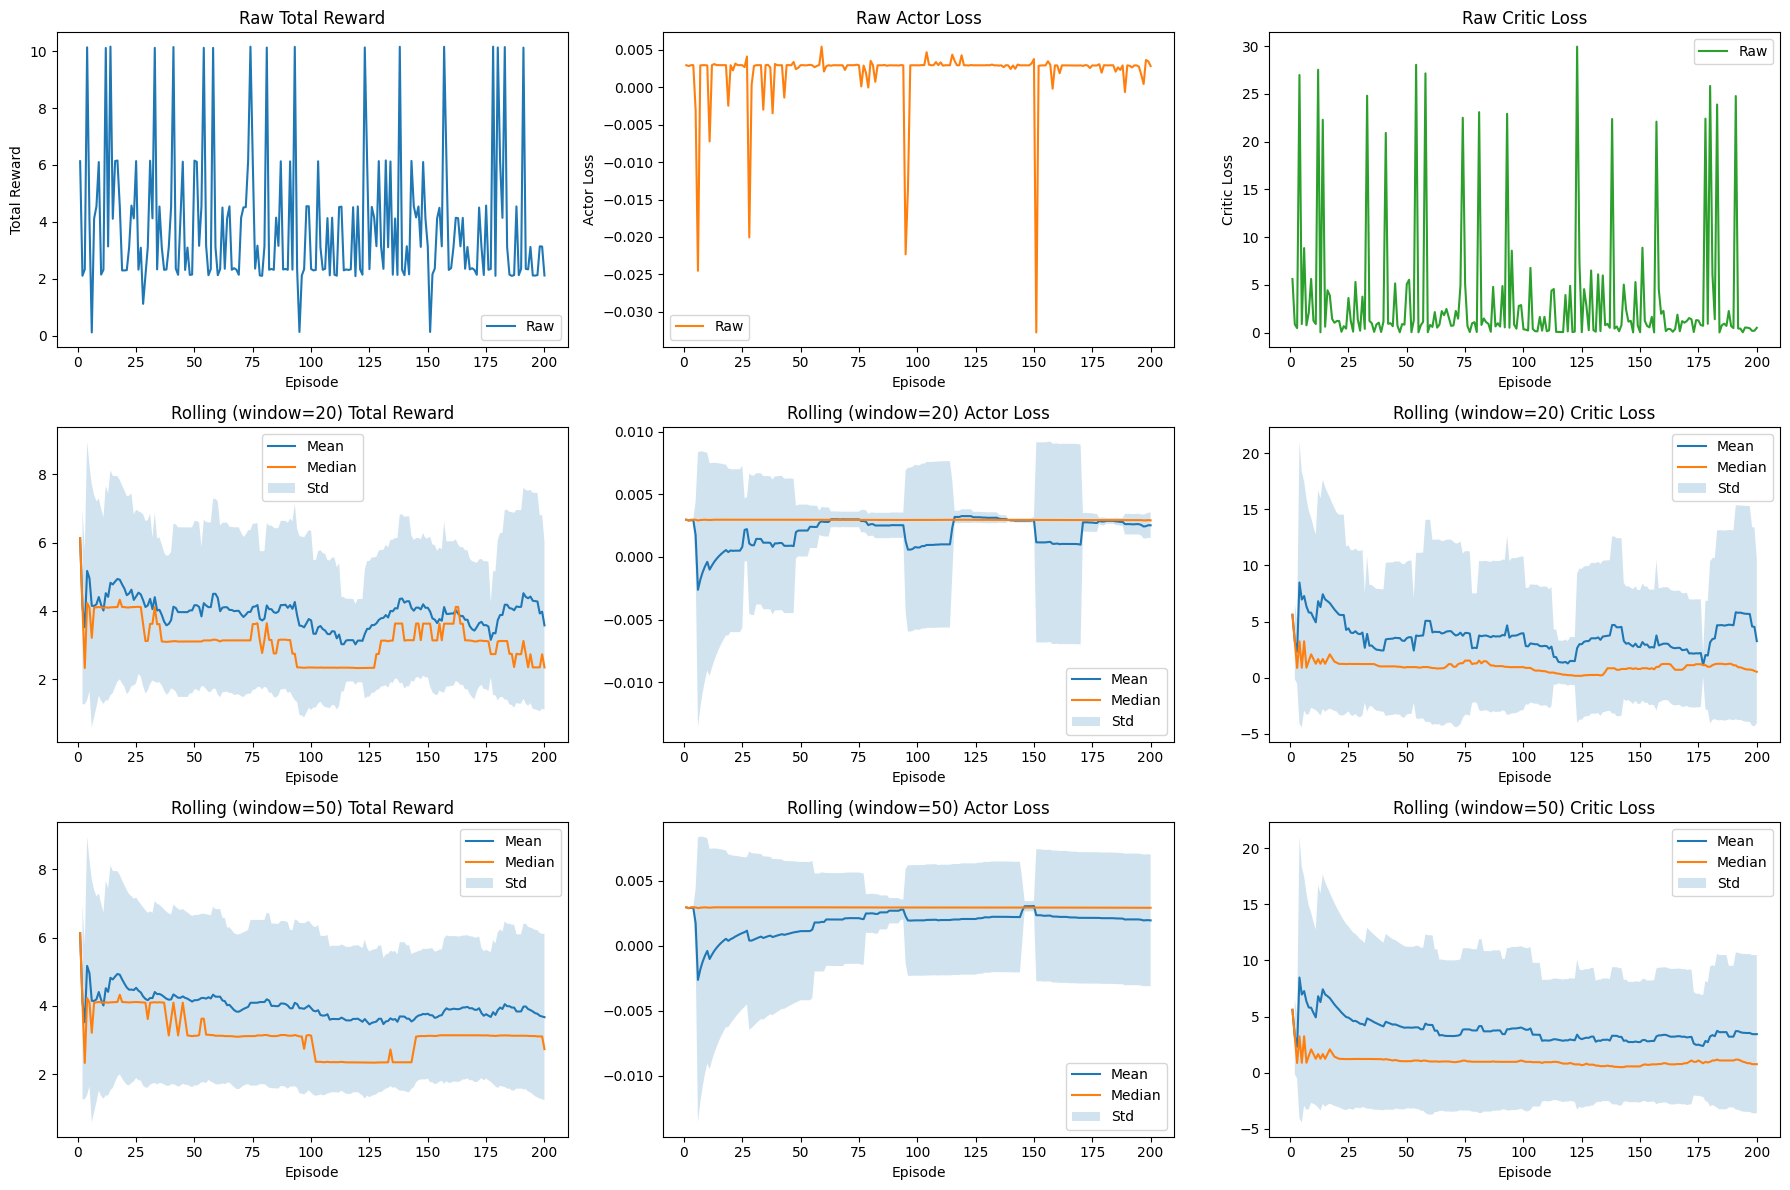

Plotting psychometric curve...


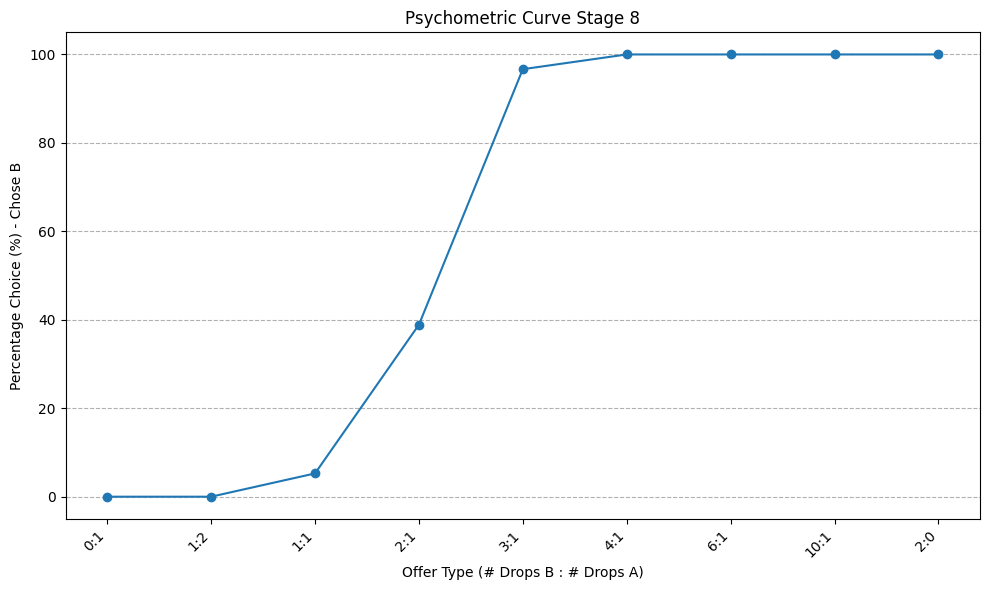

Closing environment...
Done.


In [3]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.001,
        "reward_go_fixation": -0.01,
        "duration_params": [960, 640, 1280, 1280],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 200,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 50,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 8
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 8 finished.")

    # --- Save checkpoint ---
    this_stage = 8
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_8.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 8")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.01
  reward_fixation: 0.001
  reward_go_fixation: -0.01
  duration_params: [1500, 1000, 2000, 2000]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 250
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 25
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...


2025-05-24 16:41:21.532954: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be m

Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...
Loading masks from stage 8...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_nohold_max_8/ckpt-1
Checkpoint restored successfully.
Starting training for 250 episodes...
Episode 25	Total Reward: 6.22	State [0.         1.         0.72546613 0.10887376]	Actor Loss: 0.0029	Critic Loss: 6.3037
Episode 50	Total Reward: 2.25	State [ 0.         -1.          0.03307177  0.22195026]	Actor Loss: 0.0029	Critic Loss: 0.6160
Episode 75	Total Reward: 10.28	State [ 0.         -1.          0.15455139  1.1       ]	Actor Loss: 0.0029	Critic Loss: 20.9617
Episode 100	Total Reward: 2.29	State [ 0.         -1.          0.0781983   0.48233804]	Actor Loss: 0.0029	Critic Loss: 0.7178
Episode 125	Total Reward: 4.25	State [0.         1.         0.25156933 0.12460199]	Actor Loss: 0.0031	Critic Loss: 0.5281
Episode 1

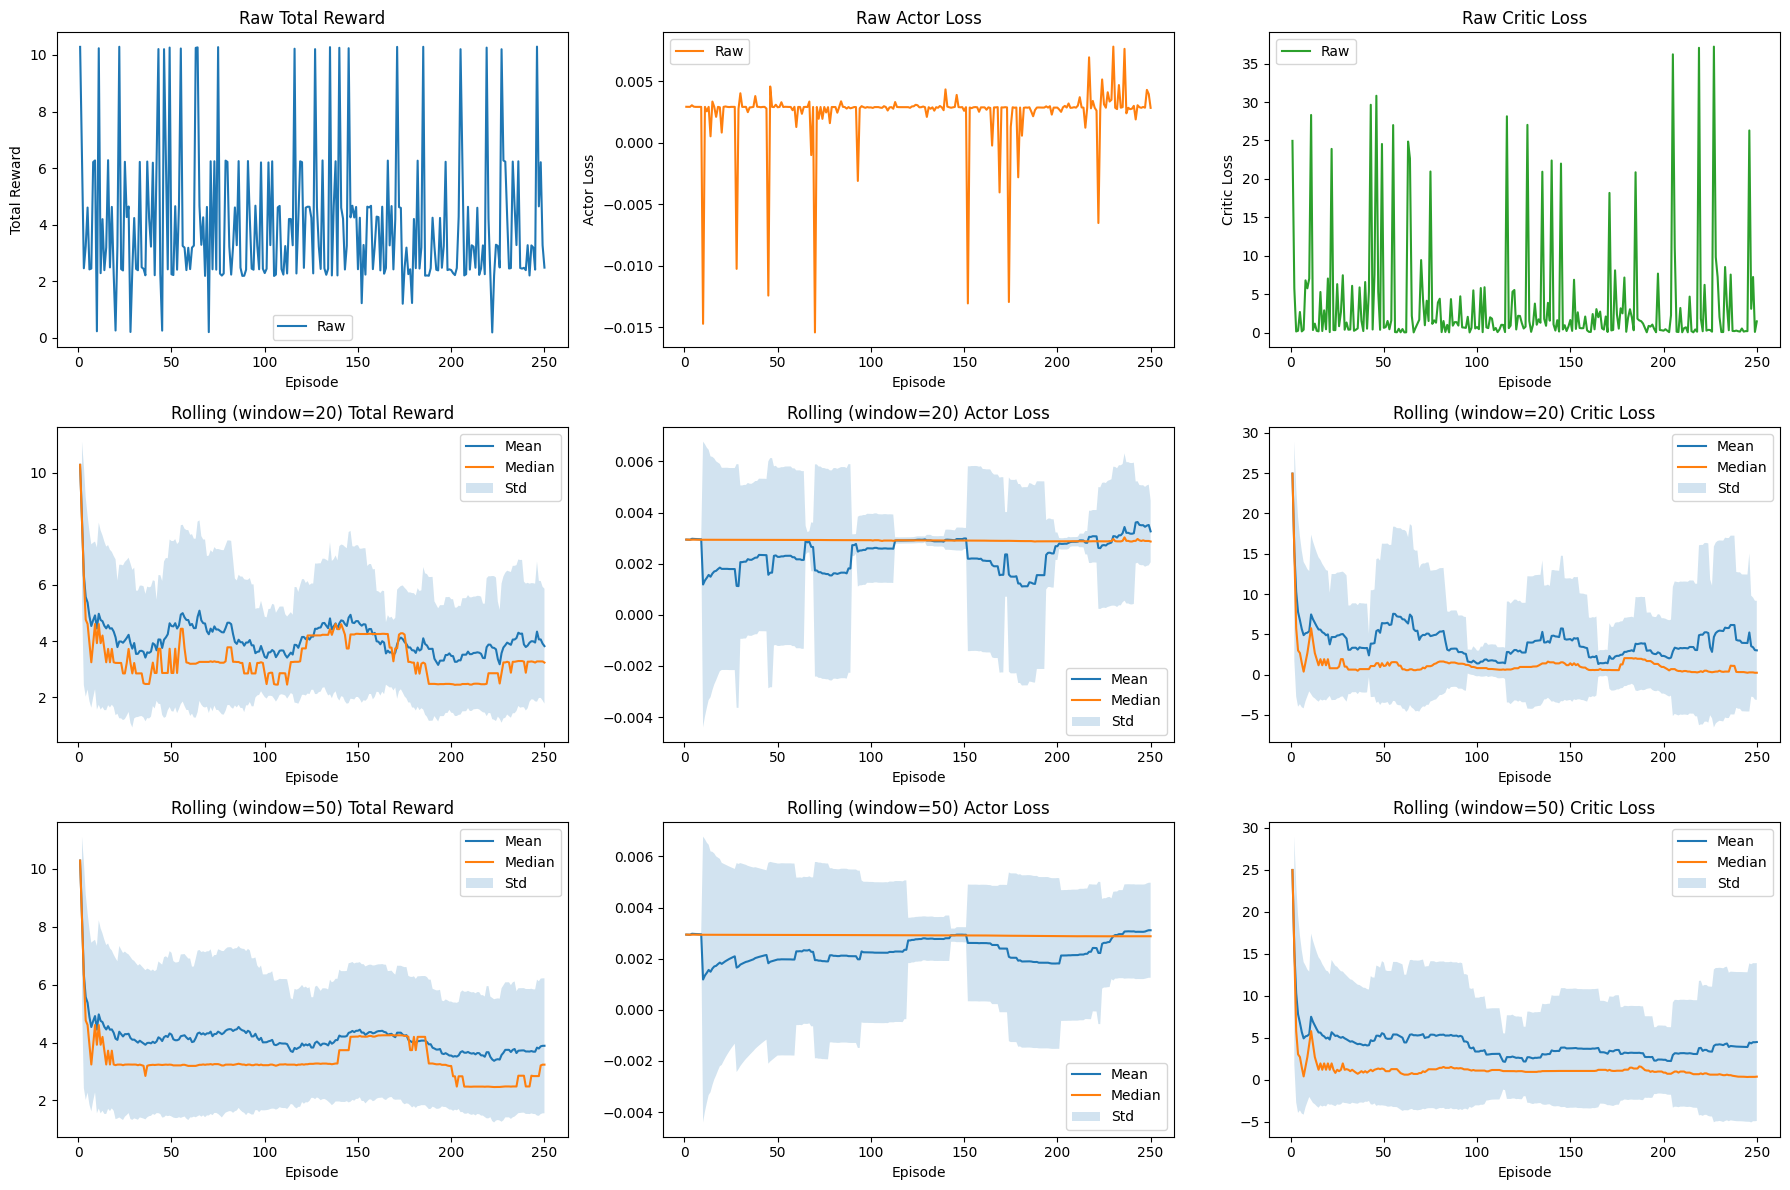

Plotting psychometric curve...


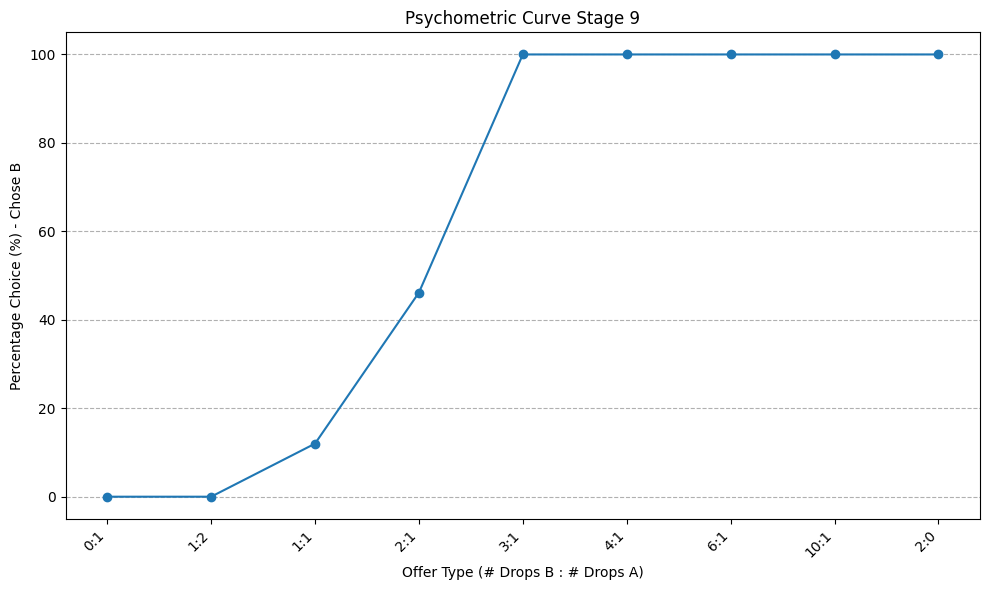

Closing environment...
Done.


In [2]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "A_to_B_ratio": 2.2,
        "reward_B": 1,
        "abort_penalty": -0.1,
        "input_noise_sigma": 0.01,
        "reward_fixation": 0.001,
        "reward_go_fixation": -0.01,
        "duration_params": [1500, 1000, 2000, 2000],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 250,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 25,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Padoa-Schioppa environment...")
    env = EconomicChoiceEnv(
        dt=config["dt"],
        A_to_B_ratio=config["A_to_B_ratio"],
        reward_B=config["reward_B"],
        abort_penalty=config["abort_penalty"],
        input_noise_sigma=config["input_noise_sigma"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 9
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_juices = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 9 finished.")

    # --- Save checkpoint ---
    this_stage = 9
    this_ckpt_dir = 'checkpoints/rnn_nohold_max'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_nohold_max_9.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_juices
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 9")

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()